In [1]:
import numpy as np
import pandas as pd
from plotnine import *

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In this notebook, we use linear interpolation to fill in missing values in the HARP data.

In [2]:
harp_data = pd.read_parquet("../../processed/hq_nc70_no.parquet")
harp_data.head()

,HARPNUM,T_REC,USFLUX,MEANGAM,MEANGBT,MEANGBZ,MEANGBH,MEANJZD,TOTUSJZ,MEANALP,...,LON_FWT,LAT_FWTPOS,LON_FWTPOS,LAT_FWTNEG,LON_FWTNEG,T_FRST1,T_LAST1,NOAA_AR,NOAA_NUM,NOAA_ARS
0,1,2010-05-01 14:00:00+00:00,5.827622e+21,23.887,73.347,77.564,31.354,-0.151826,4.860817e+12,0.000398,...,-69.996475,23.742485,-70.418633,23.806280,-67.113625,2010-05-01 00:00:00+00:00,2010-05-11 16:12:00+00:00,11067,1,11067
1,1,2010-05-01 14:12:00+00:00,5.768150e+21,24.708,71.970,76.249,31.197,-0.226835,4.908301e+12,0.000081,...,-69.953972,23.769396,-70.363503,23.788214,-67.011284,2010-05-01 00:00:00+00:00,2010-05-11 16:12:00+00:00,11067,1,11067
2,1,2010-05-01 14:24:00+00:00,5.865157e+21,25.657,74.254,82.154,32.748,-0.260023,5.577384e+12,-0.009573,...,-69.793488,23.754747,-70.199081,23.777744,-66.899902,2010-05-01 00:00:00+00:00,2010-05-11 16:12:00+00:00,11067,1,11067
3,1,2010-05-01 14:36:00+00:00,5.854875e+21,25.242,74.539,81.896,33.026,-0.199640,5.290721e+12,-0.013852,...,-69.734100,23.757551,-70.166977,23.768915,-66.779518,2010-05-01 00:00:00+00:00,2010-05-11 16:12:00+00:00,11067,1,11067
4,1,2010-05-01 14:48:00+00:00,5.854465e+21,25.876,75.671,85.297,33.556,-0.403703,5.911234e+12,-0.012455,...,-69.602234,23.720182,-70.012299,23.794512,-66.671707,2010-05-01 00:00:00+00:00,2010-05-11 16:12:00+00:00,11067,1,11067


We will fill in missing values in the columns listed below.

In [3]:
all_predictors = [
    # SHARP parameters
    "USFLUX", "MEANGAM", "MEANGBT", "MEANGBZ", "MEANGBH", "MEANJZD", "TOTUSJZ",
    "MEANALP", "MEANJZH", "TOTUSJH", "ABSNJZH", "SAVNCPP", "MEANPOT", "TOTPOT",
    "MEANSHR", "SHRGT45",
    # Patch areas and pixel counts
    "NPIX", "SIZE", "AREA", "NACR", "SIZE_ACR", "AREA_ACR"
]

In [4]:
no_nas_harp_data = harp_data.copy()
no_nas_harp_data[all_predictors] = (
    harp_data
    .groupby("HARPNUM")[all_predictors]
    .apply(lambda df: df.interpolate())
    .reset_index(drop=True)
)

We next separately number records for each HARP, e.g., the `m` records for the first HARP are numbered `0, ..., m - 1`, the `n` records for the second HARP are numbered `0, ..., n - 1`, etc. We also flag records for which at least one predictor still has a missing value. Because of how linear interpolation works, for each HARP, records that are still missing values should be in runs at the start or end.

In [5]:
no_nas_harp_data["index_in_harp"] = (
    no_nas_harp_data.groupby("HARPNUM").cumcount()
)
no_nas_harp_data["are_any_predictors_na"] = (
    no_nas_harp_data[all_predictors].isna().any(axis=1)
)

The code below verifies that records with missing values are in runs at the start or end. If a record with missing values were in the middle, then the indices of some two complete records would differ by more than one.

In [6]:
(
    no_nas_harp_data
    .groupby("HARPNUM")[["index_in_harp", "are_any_predictors_na"]]
    .apply(lambda df: (df.loc[~df["are_any_predictors_na"], "index_in_harp"].diff() > 1).any())
    .any()
)

False

For the sake of simplicity, we discard records that still have missing values. We also drop columns that are no longer needed.

In [7]:
no_nas_harp_data = (
    no_nas_harp_data[~no_nas_harp_data["are_any_predictors_na"]]
    .drop(columns=["index_in_harp", "are_any_predictors_na"])
)

We count records by HARP using both the original data and the new data.

In [8]:
orig_rec_counts = harp_data.groupby("HARPNUM").size()
new_rec_counts = no_nas_harp_data.groupby("HARPNUM").size()
all_rec_counts = (
    pd.DataFrame({
        "orig_rec_count": orig_rec_counts, "new_rec_count": new_rec_counts
    }).reset_index()
)
all_rec_counts["new_rec_count"] = (
    all_rec_counts["new_rec_count"].replace(np.nan, 0).astype("int")
)

A number of HARPs no longer have any records in the data.

In [9]:
all_rec_counts[
    all_rec_counts["new_rec_count"] == 0
].sort_values("orig_rec_count", ascending=False)

,HARPNUM,orig_rec_count,new_rec_count
3620,6715,1333,0
3588,6666,1321,0
3516,6537,1318,0
3590,6670,1307,0
3522,6550,1301,0
...,...,...,...
5772,10468,8,0
3747,6935,6,0
3528,6561,3,0
3646,6763,1,0


For the HARPs that don't have any records in the new dataset, virtually all of their records in the original dataset are of low quality.

In [10]:
no_recs_harps = all_rec_counts.loc[
    all_rec_counts["new_rec_count"] == 0, "HARPNUM"
]
harp_data.loc[
    harp_data["HARPNUM"].isin(no_recs_harps), "QUALITY"
].value_counts()

QUALITY
128      153095
65664      3659
4224       1555
32          457
72832       271
66688       234
1152        186
69760       102
68736        85
8320         36
70784        26
66592        18
5248         11
1056          3
67616         2
74880         2
0             2
66560         1
67584         1
1024          1
Name: count, dtype: Int64

We compute the absolute and relative changes in the record counts for HARPs that still have records.

In [11]:
all_rec_counts = all_rec_counts[all_rec_counts["new_rec_count"] > 0]
all_rec_counts["diff"] = all_rec_counts["orig_rec_count"] - \
    all_rec_counts["new_rec_count"]
all_rec_counts["rel_diff"] = all_rec_counts["diff"] / \
    all_rec_counts["orig_rec_count"]

Below is a histogram of the relative differences; for the vast majority of HARPs, the relative difference is close to zero.

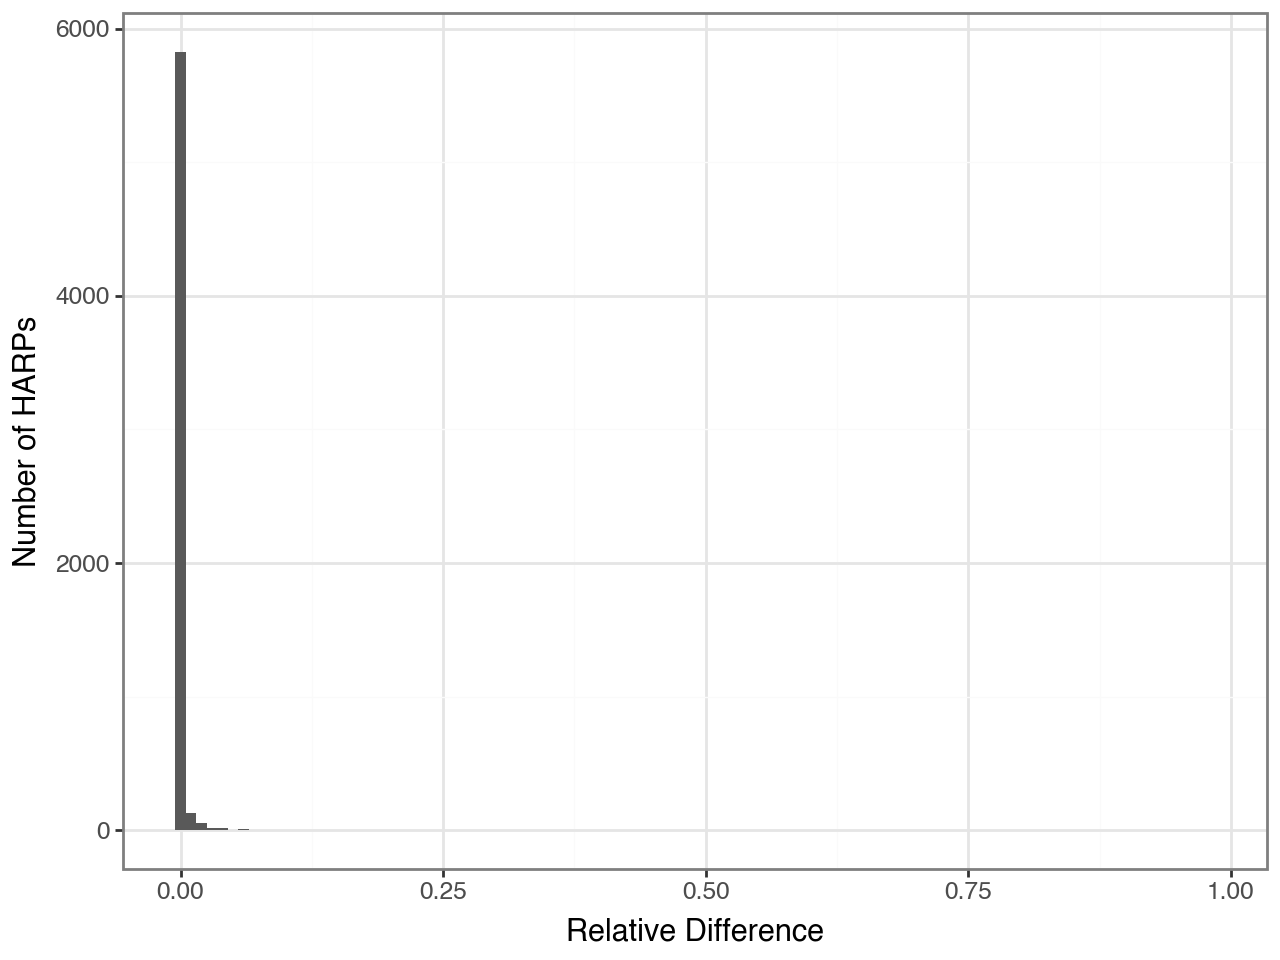

In [12]:
(
    ggplot(all_rec_counts, aes("rel_diff")) +
    geom_histogram(binwidth=0.01) +
    labs(x="Relative Difference", y="Number of HARPs") +
    theme_bw()
)

Below are the HARPs with the largest relative differences.

In [13]:
(
    all_rec_counts
    .sort_values(["rel_diff", "orig_rec_count"], ascending=False)
    .head(10)
)

,HARPNUM,orig_rec_count,new_rec_count,diff,rel_diff
3549,6603,1073,25,1048,0.976701
809,1486,21,1,20,0.952381
3552,6607,1111,135,976,0.878488
1474,2703,344,106,238,0.691860
3651,6779,868,339,529,0.609447
3849,7110,1259,588,671,0.532963
1470,2693,1225,606,619,0.505306
2307,4292,15,9,6,0.400000
3655,6784,476,300,176,0.369748
3971,7299,1100,713,387,0.351818


Save the imputed data.

In [14]:
no_nas_harp_data.to_parquet("../../processed/hq_nc70_no_nn.parquet")